In [13]:
from astropy.table import Table
import numpy as np

gaia = Table.read('Gaia.vot')

In [14]:
# load the data to the pandas dataframe
import pandas as pd
df = gaia.to_pandas()
#df.head()
print(df['l'].head())

0    313.058982
1     30.661481
2     68.558197
3     14.585552
4    313.545296
Name: l, dtype: float64


In [15]:
# see the description of the data frame
#df['b'].describe()
#df.info()

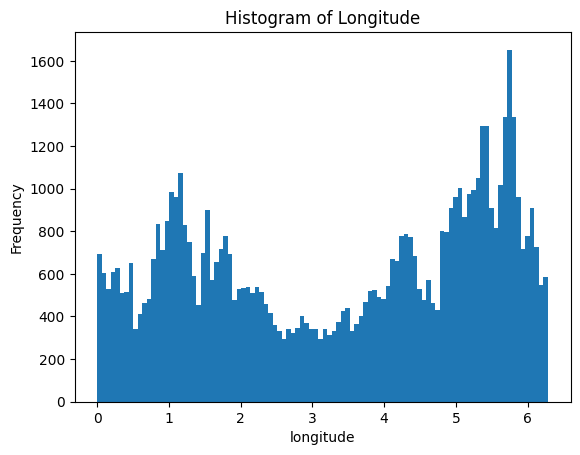

In [16]:
import matplotlib.pyplot as plt
# select the rows that have 'b' (galactic lattitude) less than 5 and greater than -5 (degrees)

bMax = 5
df = df.loc[(df['b'] >= -bMax) & (df['b'] <= bMax)]

# we have some huge relative errors on radial velocity for radial velocity near 0, impose a limit of 20%
RadVelMaxRelError = 0.2
df = df.loc[(df['radial_velocity_error'] / np.abs(df['radial_velocity'])) <= RadVelMaxRelError]
# convert to radiant, np trigonometric functions require radiants, i'd rather convert once rather than converting every time for calculations
df['l'] = np.deg2rad(df['l'])
plt.hist(df['l'], bins=100)
plt.xlabel('longitude')
plt.ylabel('Frequency')
plt.title('Histogram of Longitude')
plt.show()

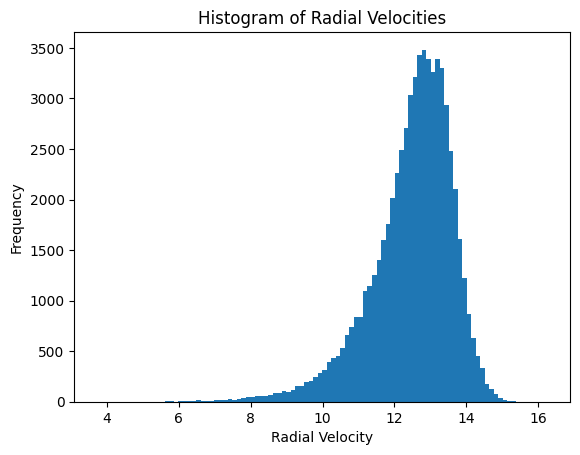

In [17]:
plt.hist(df['phot_g_mean_mag'], bins=100)
plt.xlabel('Radial Velocity')
plt.ylabel('Frequency')
plt.title('Histogram of Radial Velocities')
plt.show()

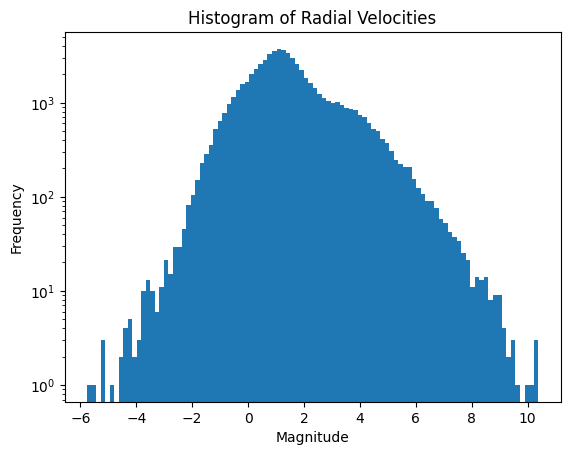

In [28]:
# Calculate distance in parsecs from parallax (milliarcseconds)
df['d'] = 1000 / df['parallax']
df['sigmad'] = 1000 * df['parallax_error'] / (df['parallax']**2)

# compute once and for all sines and cosines of l
df['cosl'] = np.cos(df['l'])
df['sinl'] = np.sin(df['l'])

# Calculate distance from center of galaxy from longitude, R and d
R = 8300
df['D'] = np.sqrt( df['d']**2 + R**2 - 2*df['d']*R*df['cosl'])

# compute sin and cos of phi
df['cosphi'] = (df['d'] * df['cosl'] - R) / df['D'] 
df['sigmacosphi'] = (df['d']*R*(df['sinl']**2) / (df['D']**3)) * df['sigmad']
df['sinphi'] = (df['d'] * df['sinl']) / df['D']
df['sigmasinphi'] = np.abs( R*df['sinl']*df['cosphi'] / (df['D']**2))*df['sigmad']

#print(df['sigmad'].head(),df['d'].head(),df['parallax'].head(),df['parallax_error'].head())

# select outside of the core
CoreRad = 1000

# plot a histogram of radial velocities with 100 bins
df['M']=df['phot_g_mean_mag']- 5*np.log10(df['d']/10)
plt.hist(df['M'], bins=100)
plt.xlabel('Magnitude')
plt.ylabel('Frequency')
plt.yscale('log')
plt.title('Histogram of Radial Velocities')
plt.show()

# for now, just take away circular corona, but we are dumping data
#df = df.loc[(df['d'] >= R + CoreRad) | (df['d'] <= R - CoreRad)]
#df.info()


Text(0, 0.5, 'l [rad]')

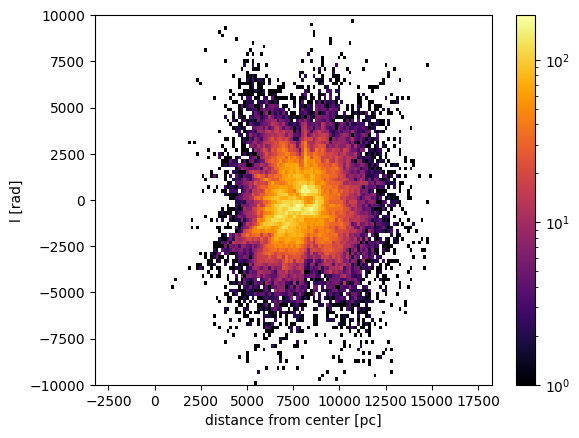

In [29]:
from matplotlib.colors import LogNorm
PhiMax = 2*np.pi

dfmag = df.loc[(df['M'] <= 4)]

plt.hist2d(-dfmag['D']*dfmag['cosphi'], dfmag['D']*dfmag['sinphi'], bins = (100, 100), norm=LogNorm(), range=((0, 15000), (-10000, 10000)), cmap = "inferno")
plt.colorbar()
plt.axis('equal')
plt.xlabel("distance from center [pc]")
plt.ylabel("l [rad]")

Text(0, 0.5, 'l [rad]')

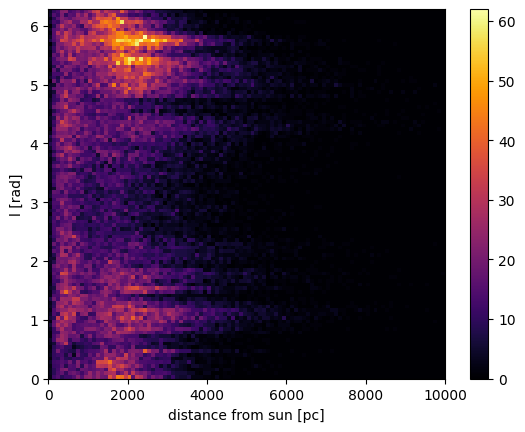

In [35]:
# where are the stars in terms of radial distance and l?

PhiMax = 2*np.pi

plt.hist2d(df['d'], df['l'], bins = (100, 100), range=((0, 10000), (0, PhiMax)), cmap = "inferno")
plt.colorbar()
plt.xlabel("distance from sun [pc]")
plt.ylabel("l [rad]")

Text(0, 0.5, 'relative error on distance [a.u.]')

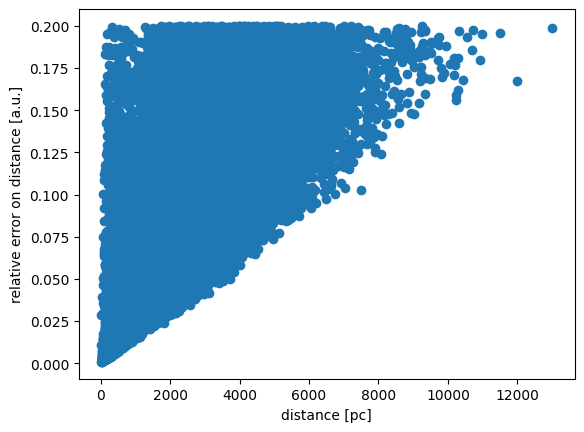

In [42]:
# how are the relative errors distributed?
# by error propagation, the relative error on the parallax is equal to that on the distance
plt.scatter(df['d'], df['parallax_error'] / df['parallax'])
plt.xlabel("distance [pc]")
plt.ylabel("relative error on distance [a.u.]")

Text(0, 0.5, 'relative error on radial velocity')

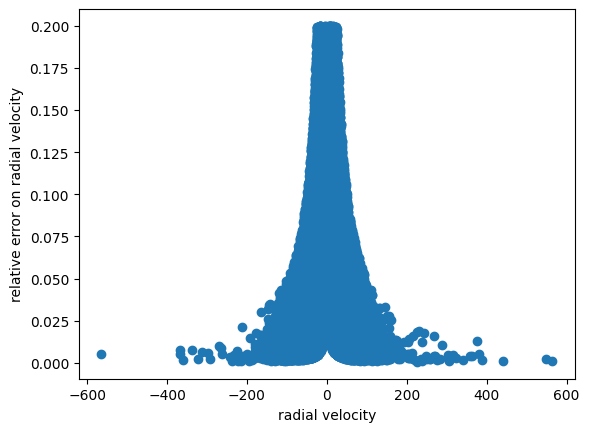

In [43]:
plt.scatter(df['radial_velocity'], df['radial_velocity_error'] / np.abs(df['radial_velocity']))
plt.xlabel('radial velocity')
plt.ylabel('relative error on radial velocity')

In [44]:
# test values to see histogram of differences
VRot_try = 200
U_try = 11.1
V_try = 12.24

df['v_rad_model'] = VRot_try * ( df['sinphi'] * df['cosl'] - (1 + df['cosphi'])*df['sinl']) - U_try*df['cosl'] - V_try * df['sinl']
df['vradDiff'] = df['radial_velocity'] - df['v_rad_model']

Text(0, 0.5, 'counts')

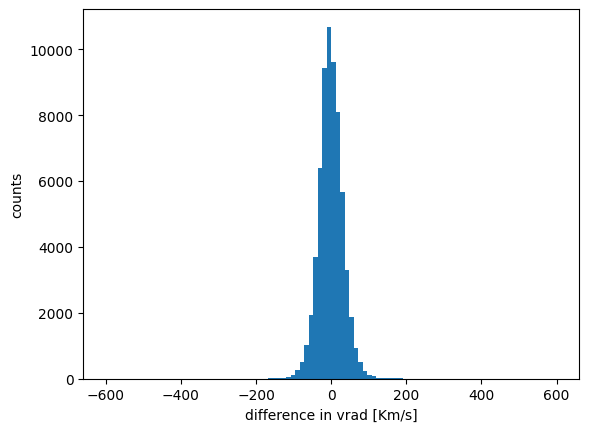

In [45]:
plt.hist(df['vradDiff'], bins = 100, range = (-600, 600))
plt.xlabel("difference in vrad [Km/s]")
plt.ylabel("counts")

Text(0, 0.5, 'difference in vrad [Km/s]')

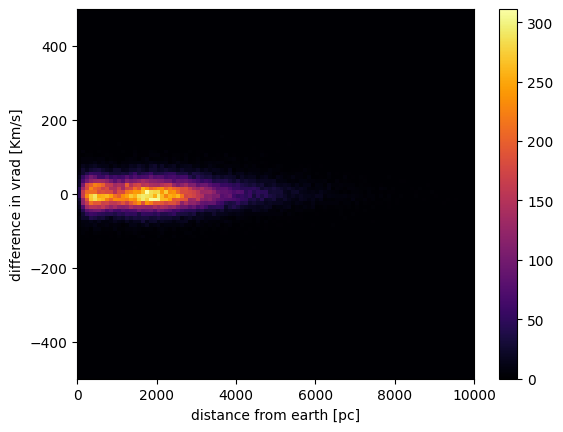

In [46]:
plt.hist2d(df['d'], df['vradDiff'], bins = (100, 100), range=((0, 10000), (-500, 500)), cmap = "inferno");
plt.colorbar()
plt.xlabel("distance from earth [pc]")
plt.ylabel("difference in vrad [Km/s]")


Text(0, 0.5, 'difference in vrad [Km/s]')

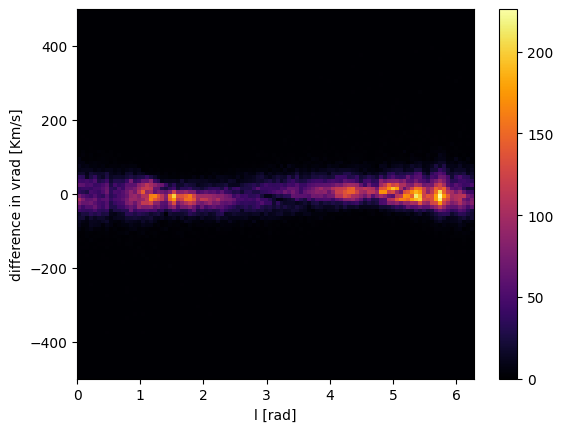

In [47]:
plt.hist2d(df['l'], df['vradDiff'], bins = (100, 100), range=((0, 2*np.pi), (-500, 500)), cmap = "inferno");
plt.colorbar()
plt.xlabel("l [rad]")
plt.ylabel("difference in vrad [Km/s]")

C:\Users\sedan\AppData\Local\Temp\ipykernel_34300\3288398337.py:14: RuntimeWarning: divide by zero encountered in log
  plt.pcolormesh(xcenters, ycenters, np.log(hist.T),  cmap="inferno")
C:\Users\sedan\AppData\Local\Temp\ipykernel_34300\3288398337.py:14: RuntimeWarning: invalid value encountered in log
  plt.pcolormesh(xcenters, ycenters, np.log(hist.T),  cmap="inferno")


Text(0.5, 1.0, 'Contour plot of log(vradDiff) as a function of d and l')

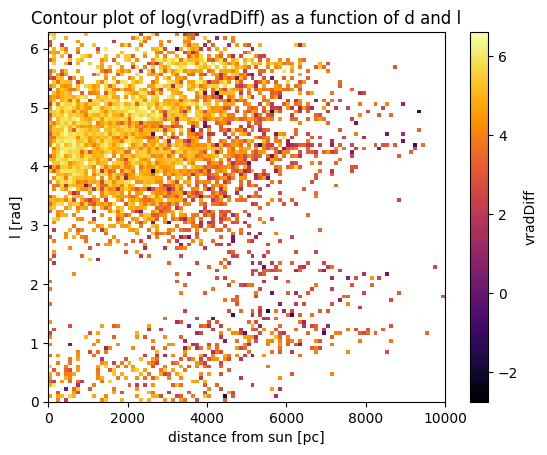

In [48]:
# Create a contour plot of vradDiff as a function of d and l
d_values = df['d']
l_values = df['l']
vrad_diff_values = df['vradDiff']

# Create a 2D histogram for contour plotting
hist, xedges, yedges = np.histogram2d(d_values, l_values, bins=(100, 100), range=((0, 10000), (0, 2 * np.pi)), weights=vrad_diff_values)

# Compute the bin centers
xcenters = (xedges[:-1] + xedges[1:]) / 2
ycenters = (yedges[:-1] + yedges[1:]) / 2

# Create the contour plot
plt.pcolormesh(xcenters, ycenters, np.log(hist.T),  cmap="inferno")
plt.colorbar(label="vradDiff")
plt.xlabel("distance from sun [pc]")
plt.ylabel("l [rad]")
plt.title("Contour plot of log(vradDiff) as a function of d and l")


In [49]:
# variance on difference, for now, just use error on vrad, bu errors on parallax must be propagated
df['var'] = df['radial_velocity_error']**2

In [ ]:
# intervals for the parameters


In [ ]:
# log likelyhood 
def log_like(par,vrad):
    vrot,u,v=par
    return -0.5*np.sum((vrad-a*xs-b)**2)/(0.1**2)


In [2]:
import emcee as mc